# BCDA Synthetic Data Exploration with FHIR Views

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/fhir-py/blob/main/examples/bcda_synthetic_data_exploration.ipynb) __(Synthetic data only--not HIPAA compliant)__

[__Deploy on a Vertex AI Notebook__](https://console.cloud.google.com/vertex-ai/workbench/user-managed/deploy?download_url=https:%2F%2Fraw.githubusercontent.com%2Fgoogle%2Ffhir-py%2Fmain%2Fexamples%2Fbcda_synthetic_data_exploration.ipynb) [__(HIPAA Compliant and BAA Covered According to GCP)__](https://cloud.google.com/security/compliance/hipaa#covered-products)

This notebook uses FHIR Views to explore claims data from Medicare's Beneficiary Claims Data API (BCDA), which can be imported to BigQuery and FHIR Store out of the box using these [open source tools](https://github.com/google/medical_claims_tools). Accountable Care Organizations that participate in the Medicare Shared Savings Program can use those tools to fetch data periodically from BCDA and use tools like FHIR Views to build analyses over that data.

FHIR Views seeks to simplify building views over nested FHIR data via a python API similar to the [FHIR Path specification](https://www.hl7.org/fhir/fhirpath.html). The FHIR Views toolkit will generate BigQuery SQL under the hood to build (and optionally materialize) the views specified by the user. Simplified flat views over the FHIR data can then be used for more detailed downstream analysis.

It will be helpful to take a look at the [FHIR Views Documentation](https://github.com/google/fhir-py/blob/main/google-fhir-views/README.md) as well as the example [statin analysis](https://github.com/google/fhir-py/blob/main/examples/statin_analysis_example.ipynb) notebook before jumping in here.

__Note: the saved results visible in this notebook are from synthetic BCDA data__, however the analyses in this notebook can be run over any BCDA data imported to FHIR Store and BigQuery via the [open source tools](https://github.com/google/medical_claims_tools) or other fashion.

## Installation
This library can by installed from pypi by simply running:

```
pip install google-fhir-views[r4,bigquery]
```

It's recommended to do so *before* starting the notebook kernel to avoid any dependency version issues.

Running the cell below will attempt to install the libraries in your notebook environment, after which you will need to manually restart the kernel.

In [ ]:
!pip install google-fhir-views[r4,bigquery]

# Setup and Authentication
Users of this notebook will need to obtain BigQuery credentials. If you're using Vertex AI Notebooks, the runner should by default have access to query BigQuery datasets in your project. If you are using Colab, running the cell below should set up the needed authentication.


__Please note that Colab is not HIPAA eligible and should only be used with synthetic data. Please use Vertex AI Notebooks if a HIPAA environment is needed.__

There are a few other ways to get this setup, but the best option is likely
[this example](https://cloud.google.com/bigquery/docs/authentication/end-user-installed#bigquery-enduser-installed-packages-python).

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('NOTE: COLAB IS NOT HIPAA ELIGIBLE, please only continue with synthetic data.')
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

In [ ]:
#@title Parameters
PROJECT_ID = "betazed" #@param {type:"string"}
VIEW_DATASET = "fhir_views" #@param {type:"string"}

In [ ]:
import datetime
from google.cloud import bigquery as bq
from google.fhir.views import r4, bigquery_runner
from google.cloud import bigquery

bqclient = bigquery.Client(project=PROJECT_ID)

# Create the BigQuery runner we will use to evaluate our FHIR views. 
runner = bigquery_runner.BigQueryRunner(
    bqclient,
    fhir_dataset='betazed.bcda_synthetic_advanced_large',
    view_dataset=f'{PROJECT_ID}.{VIEW_DATASET}')

# Load views based on the base FHIR R4 profile definitions.
views = r4.base_r4()

## Introduction

Using just the [ExplanationOfBenefit](https://build.fhir.org/explanationofbenefit.html) resource, we can create a view of the basic ExplanationOfBenefit profile and build more complex analyses upon it.

In [ ]:
eob = views.view_of('ExplanationOfBenefit')

If we were to save eob to a table using `runner.to_dataframe(eob)` it would write the entire table stored in `betazed.bcda_synthetic_advanced_large.ExplanationOfBenefit` to a dataframe. Since this is a very large and complicated table with nested information we might not need for the particular analysis at hand, in most cases, we do not want to do this. 

Instead, we can use the FHIR Views APIs to built flat, filtered views of just the data we need for the analysis at hand.

## Claim Types

Let's take a closer look at the types of ExplanationOfBenefits in our dataset, by summarizing the ExplanationOfBenefit.type values across the entire dataset.

In [ ]:
type_summary = runner.summarize_codes(eob, eob.type)
type_summary

,system,code,display,count
0,http://terminology.hl7.org/CodeSystem/claim-type,institutional,Institutional,729947
1,https://bluebutton.cms.gov/resources/variables...,40,Hospital Outpatient claim,644890
2,https://bluebutton.cms.gov/resources/codesyste...,OUTPATIENT,None,644890
3,http://terminology.hl7.org/CodeSystem/claim-type,professional,Professional,613120
4,https://bluebutton.cms.gov/resources/variables...,71,"Local carrier non-durable medical equipment, p...",574795
5,https://bluebutton.cms.gov/resources/codesyste...,CARRIER,None,574795
6,https://bluebutton.cms.gov/resources/codesyste...,PDE,None,439504
7,http://terminology.hl7.org/CodeSystem/claim-type,pharmacy,Pharmacy,439504
8,https://bluebutton.cms.gov/resources/variables...,60,Inpatient claim,74137
9,https://bluebutton.cms.gov/resources/codesyste...,INPATIENT,None,74137


A couple things to notice--there are a couple different code systems to describe the types of our ExplanationOfBenefits. Let's use some pandas APIs to organize this a little better:

In [ ]:
type_summary.groupby(['system','count']).first().sort_index(ascending=False)

code  \
system                                             count                   
https://bluebutton.cms.gov/resources/variables/... 644890             40   
                                                   574795             71   
                                                   74137              60   
                                                   38325              10   
                                                   6724               20   
                                                   4196               50   
https://bluebutton.cms.gov/resources/codesystem... 644890     OUTPATIENT   
                                                   574795        CARRIER   
                                                   439504            PDE   
                                                   74137       INPATIENT   
                                                   38325             HHA   
                                                   6724              SNF   
                                                   4196          HOSPICE   
http://terminology.hl7.org/CodeSystem/claim-type   729947  institutional   
                                                   613120   professional   
                                                   439504       pharmacy   

                                                                                                     display  
system                                             count                                                      
https://bluebutton.cms.gov/resources/variables/... 644890                          Hospital Outpatient claim  
                                                   574795  Local carrier non-durable medical equipment, p...  
                                                   74137                                     Inpatient claim  
                                                   38325                      Home Health Agency (HHA) claim  
                                                   6724    Non swing bed Skilled Nursing Facility (SNF) c...  
                                                   4196                                        Hospice claim  
https://bluebutton.cms.gov/resources/codesystem... 644890                                               None  
                                                   574795                                               None  
                                                   439504                                               None  
                                                   74137                                                None  
                                                   38325                                                None  
                                                   6724                                                 None  
                                                   4196                                                 None  
http://terminology.hl7.org/CodeSystem/claim-type   729947                                      Institutional  
                                                   613120                                       Professional  
                                                   439504                                           Pharmacy

Let's proceed with the `https://bluebutton.cms.gov/resources/codesystem/eob-type` code system for some our of claim type specific explorations below.

## PDE (Pharmacy) Claims Exploration

Let's take a look at prescription drug event (PDE) data that are submitted when a prescription is filled under Medicare Part D.

To do so, we can use FHIR View's rich support for valuesets filter to claims that are a member of the PDE claim type valueset. In FHIR Views, one can specify valuesets manually (as below) or [pull valuesets](https://github.com/google/fhir-py/blob/main/google-fhir-views/README.md#working-with-code-values) from an established authority like the [Value Set Authority Center](https://vsac.nlm.nih.gov/).

In [ ]:
pharmacy_value_set = r4.value_set('urn:example:valueset:pharmacy_claims').with_codes(
    'https://bluebutton.cms.gov/resources/codesystem/eob-type', ['PDE']).build()

Now that we have a valueset defined, let's build a view of the ExplanationOfBenefits that is filtered to include only those in our valueset _and_ is a flat representation of data we're interested in.

In [ ]:
eob_pde_codes = (
    eob.select({
        'eob_id': eob.id,
        'patient': eob.patient.idFor('Patient'),
        'first_ndc': eob.item.productOrService.coding.where(
            eob.item.productOrService.coding.system == 'http://hl7.org/fhir/sid/ndc')
              .first().code,
        'serviced_date': eob.item.first().serviced.ofType('date'),
    }).where(eob.type.memberOf(pharmacy_value_set)))

runner.to_dataframe(eob_pde_codes, limit=5) # Preview 5 rows of the eob_pde_codes view.

,eob_id,patient,first_ndc,serviced_date
0,pde--10000000138,-10000000000009,10267002205,2013-11-29
1,pde--10000000140,-10000000000009,63481062925,2014-02-06
2,pde--10000000143,-10000000000009,16590061860,2014-02-06
3,pde--10000000147,-10000000000009,60505700102,2014-03-28
4,pde--10000000149,-10000000000009,63629386106,2014-08-20


From this __clean, flat, and filtered view__ of the otherwise complex/nested FHIR data, we can easily build follow on analyses.

Also note, that FHIR views are composable and build on each other easily. For example, if we wanted to create a subview of `eob_pde_codes` for those with serviced.date in 2012 we can do:

In [ ]:
import datetime
start_date = datetime.date(2012,1,1)
end_date = datetime.date(2013,1,1)

eob_pde_codes_2012 = eob_pde_codes.where(
    eob_pde_codes.serviced_date >= start_date, 
    eob_pde_codes.serviced_date < end_date)

runner.to_dataframe(eob_pde_codes_2012, limit=5).style.set_caption('2012 EOB PDEs')

,eob_id,patient,first_ndc,serviced_date
0,pde--10000000851,-10000000000034,00136680141,2012-05-25
1,pde--10000001698,-10000000000070,49999099310,2012-01-13
2,pde--10000001698,-10000000000070,49999099310,2012-01-13
3,pde--10000001699,-10000000000070,54569346700,2012-07-06
4,pde--10000001699,-10000000000070,54569346700,2012-07-06


#### Save the view in BigQuery for downstream use
Once we've defined a clean, flattened view of interest (like `eob_pde_codes_2012` above), we can save it as a [BigQuery view](https://cloud.google.com/bigquery/docs/views) back to a BigQuery dataset. Then, we can query this flattened view as if it was a BigQuery table, even from outside this notebook!

Because of the way BigQuery views work, whenever you query this view "virtual table" it will always be up-to-date with the data in the underlying FHIR data BigQuery tables.

In [ ]:
runner.create_database_view(eob_pde_codes_2012, "eob_pde_codes_2012")

This creates the `eob_pde_codes_2012` view in our `view_dataset` we specfied in the setup. We can now query it like a BigQuery table from anywhere using SQL, for example:

In [ ]:
%%bigquery
SELECT * from fhir_views.eob_pde_codes_2012 limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.96rows/s]


,eob_id,patient,first_ndc,serviced_date
0,pde--10000000851,-10000000000034,00136680141,2012-05-25
1,pde--10000001698,-10000000000070,49999099310,2012-01-13
2,pde--10000001698,-10000000000070,49999099310,2012-01-13
3,pde--10000001699,-10000000000070,54569346700,2012-07-06
4,pde--10000001699,-10000000000070,54569346700,2012-07-06


Now that this view is in BigQuery, it can be queried from other places for dashboarding like Looker or DataStudio.

### Most common PDEs

Let's use the views we've created to look at the most common PDEs in 2012.

In [ ]:
eob_pde_codes_2012_df = runner.to_dataframe(eob_pde_codes_2012)
grouped = eob_pde_codes_2012_df.groupby('first_ndc')['first_ndc'].count().reset_index(name='count')
eobs_grouped_and_sorted = grouped.sort_values('count', ascending=False)[:10]

<AxesSubplot:title={'center':'2012 Most Frequent PDE Drugs'}, xlabel='NDC', ylabel='Count'>

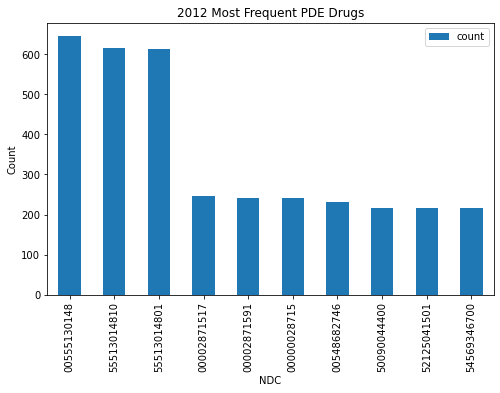

In [ ]:
eobs_grouped_and_sorted.plot.bar(
    x='first_ndc', 
    title="2012 Most Frequent PDE Drugs", 
    ylabel="Count", 
    xlabel="NDC", 
    figsize=(8,5))

### Patients with the Most PDEs in 2012

In [ ]:
eob_pde_codes_2012_df.groupby('patient')['patient'].count().reset_index(name='count').sort_values('count', ascending=False)[:10]

,patient,count
3752,-10000000008485,320
1412,-10000000003192,256
1833,-10000000004122,246
129,-10000000000307,244
2119,-10000000004810,200
471,-10000000001065,176
2233,-10000000005053,168
35,-10000000000076,160
3737,-10000000008459,152
2956,-10000000006706,152


### Outpatient Procedures (in 2012)
Let's look at the most common primary outpatient procedures in 2012.

In [ ]:
outpatient_claims_valueset = r4.value_set('urn:example:valueset:outpatient_claims').with_codes(
    'https://bluebutton.cms.gov/resources/codesystem/eob-type', ['OUTPATIENT']).build()
sys = 'http://hl7.org/fhir/sid/icd-10'
coding = views.expression_for('Coding')

eob_outpatient_proc_codes = (
    eob.select({
        'eob_id': eob.id,
        'patient': eob.patient.idFor('Patient'),
        'first_procedure_code': (eob.procedure.first().procedure.ofType('CodeableConcept').coding
                                 .where(coding.system == 'http://hl7.org/fhir/sid/icd-10').code),
        'first_procedure_date': eob.procedure.first().date,
    }).where(eob.type.memberOf(outpatient_claims_valueset), eob.procedure.exists()))

eob_outpatient_proc_codes_2012 = eob_outpatient_proc_codes.where(
    eob_outpatient_proc_codes.first_procedure_date >= datetime.date(2012,1,1), 
    eob_outpatient_proc_codes.first_procedure_date < datetime.date(2013,1,1))

eob_outpatient_proc_codes_2012_df = runner.to_dataframe(eob_outpatient_proc_codes_2012)
eob_outpatient_proc_codes_2012_df

,eob_id,patient,first_procedure_code,first_procedure_date
0,outpatient--10000002743029,-10000000008606,0D9K3ZX,2012-06-16 04:00:00+00:00
1,outpatient--10000001805288,-10000000005745,0DBK0ZX,2012-10-03 04:00:00+00:00
2,outpatient--10000003110527,-10000000009804,0D9L0ZX,2012-07-14 04:00:00+00:00
3,outpatient--10000003110530,-10000000009804,0D9L0ZX,2012-07-14 04:00:00+00:00
4,outpatient--10000000300731,-10000000000956,09JY4ZZ,2012-04-17 04:00:00+00:00
...,...,...,...,...
4003,outpatient--10000001833122,-10000000005817,09JY4ZZ,2012-03-06 05:00:00+00:00
4004,outpatient--10000001833179,-10000000005817,09JY4ZZ,2012-03-06 05:00:00+00:00
4005,outpatient--10000001833003,-10000000005817,09JY4ZZ,2012-03-06 05:00:00+00:00
4006,outpatient--10000001833118,-10000000005817,09JY4ZZ,2012-03-06 05:00:00+00:00


In [ ]:
# Let's look at the most common procedures in 2012
(eob_outpatient_proc_codes_2012_df
 .groupby('first_procedure_code')['first_procedure_code']
 .count()
 .reset_index(name='count')
 .sort_values('count', ascending=False)
 .style.set_caption('Most common Procedures in 2012'))

,first_procedure_code,count
11,0U2DXHZ,824
29,BW03ZZZ,542
0,09JY4ZZ,508
22,0VB08ZX,498
23,0VB08ZZ,289
10,0DBM7ZX,160
19,0VB03ZZ,120
24,0VC07ZZ,120
16,0V908ZX,115
21,0VB07ZX,102


In [ ]:
# Let's look at patients with the most procedures in 2012
proc_by_patient = (eob_outpatient_proc_codes_2012_df
 .groupby('patient')['patient']
 .count()
 .reset_index(name='count')
 .sort_values('count', ascending=False))
proc_by_patient[:10].style.set_caption("10 Patients with most procedures in 2012")

,patient,count
68,-10000000005704,282
101,-10000000008278,249
70,-10000000005817,249
24,-10000000002008,177
98,-10000000007972,128
13,-10000000001248,121
0,-10000000000076,112
58,-10000000004448,105
4,-10000000000325,104
118,-10000000009487,86


## Outpatient Diagnoses

Let's look at the most common principal diagnoses in our dataset.

In [ ]:
outpatient_claims_valueset = r4.value_set('urn:example:valueset:outpatient_claims').with_codes(
    'https://bluebutton.cms.gov/resources/codesystem/eob-type', ['OUTPATIENT']).build()

principal_diagnosis_valueset = r4.value_set('urn:example:valueset:principal_diagnosis').with_codes(
    'http://terminology.hl7.org/CodeSystem/ex-diagnosistype', ['principal']).build()

is_principal_diagnosis = eob.diagnosis.type.memberOf(principal_diagnosis_valueset).anyTrue()
coding = views.expression_for('Coding')  # shorthand for referring to "coding" fields in views below.

eob_outpatient_codes = (
    eob.select({
        'eob_id': eob.id,
        'patient': eob.patient.idFor('Patient'),
        # Gets the first principal diagnosis's ICD-10 Code
        'principal_diagnosis_icd10': eob.diagnosis.where(is_principal_diagnosis).first().diagnosis.ofType('CodeableConcept').coding.where(coding.system == 'http://hl7.org/fhir/sid/icd-10').code,
    }).where(eob.type.memberOf(outpatient_claims_valueset), is_principal_diagnosis))

In [ ]:
df = runner.to_dataframe(eob_outpatient_codes)

In [ ]:
principal_dx = df.groupby('principal_diagnosis_icd10')['principal_diagnosis_icd10'].count().reset_index(name='count').sort_values('count', ascending=False)

In [ ]:
top_10_principal_dx = principal_dx[:10]
top_10_principal_dx

,principal_diagnosis_icd10,count
34,E669,81993
35,E781,57951
36,E785,48231
17,D649,46314
89,J329,41546
33,E119,38068
131,O039,33194
162,R739,23805
55,I10,21655
136,P292,21477


<AxesSubplot:title={'center':'Most Frequent Principal Diagnoses'}, xlabel='Diagnosis ICD10', ylabel='Count'>

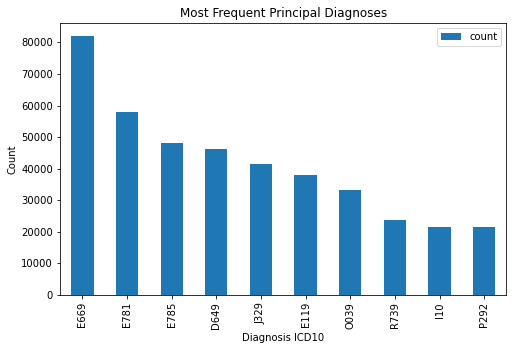

In [ ]:
top_10_principal_dx.plot.bar(
    x='principal_diagnosis_icd10', 
    title="Most Frequent Principal Diagnoses", 
    ylabel="Count", 
    xlabel="Diagnosis ICD10", 
    figsize=(8,5))